Model_VGG

In [1]:
# model
import torch
import torch
import torch.nn as nn
from torchsummary import summary
import torch
import os
import torch.nn as nn
import cv2
import numpy
from torchsummary import summary

class  selayer(nn.Module):
    def __init__(self,channel, ratio=16):
        super(selayer,self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)  # 全局平均池化 sq操作
        self.fc = nn.Sequential(  # 两个全连接层，ex操作
            nn.Linear(channel, channel//ratio, bias=False),  # 从 c -> c/r
            nn.ReLU(inplace=True),
            nn.Linear(channel//ratio, channel, bias=False), # 从 c/r  -> c
            nn.Sigmoid()
        )
    def forward(self,x ):
        # print(x.size())
        b, c, h, w = x.size() 
        y = self.gap(x).view(b,c) # sq 
        y = self.fc(y).view(b,c,1,1) # ex
        return x*(y.expand_as(x)) # 将得到的权重乘以原来的特征图x

class VGG(nn.Module):
    def __init__(self, num_class=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(1, 1), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(1, 1), stride=(1, 1), padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=7*7*512, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),

            nn.Linear(4096, num_class)
        )

    def forward(self, x):
        # print(x.size())
        x = self.feature(x)
        # print(x.size())
        x = torch.flatten(x, start_dim=1) 
        x = self.fc(x)
        # x = nn.Softmax(x)
        return x



Vgg = VGG(num_class=10)

print(summary(Vgg, (3,224,224), device='cpu'))


c:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [2]:
# VGG_mine
import torch
from torchvision.models import vgg16
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



def vgg_mine(num_class=3):
    VGG = vgg16(pretrained=False)
    VGG.load_state_dict(torch.load('./VGG/vgg16-397923af.pth'))
    # VGG.features[3].add_module('se', selayer(64))
    # VGG.features[8].add_module('se', selayer(128))

    # VGG.features[15].add_module('se', selayer(256))

    # VGG.features[22].add_module('se', selayer(512))
    # VGG.features[29].add_module('se', selayer(512))
    VGG.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_class, bias=True),
   
    )
    return VGG


Train

In [3]:
# train
import torch.utils.data
import torchvision
import torchvision.datasets.utils
import os
import matplotlib.pyplot as plt
import json
import torch.nn as nn
# from VGG_model import VGG
from torchvision.models import vgg16
from tqdm import tqdm
import numpy
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
import torch
torch.cuda.empty_cache()
transforms = {
    'train': torchvision.transforms.Compose(
        [torchvision.transforms.Resize((224, 224)),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    'val': torchvision.transforms.Compose(
        [torchvision.transforms.Resize((224,224)),
        #  torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}
path_now = os.path.abspath('./')
data_path = os.path.join(path_now, 'data_set/MT')
# print(data_path)
train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(data_path, 'train'),
    transform=transforms['train']
)
val_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(data_path, 'val'),
    transform=transforms['val']
)
train_num = len(train_dataset)

# label_dic
# {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
train_dic = train_dataset.class_to_idx
# print(train_dic.items())
label_dic = dict((I, V) for V, I in train_dic.items())
# print(label_dic)
json_dic = json.dumps(label_dic)
with open('./VGG/VGG_label_dic.json', 'w') as js:
    js.write(json_dic)
batch_size = 8
image_train = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=batch_size
)
image_val = torch.utils.data.DataLoader(
    dataset=val_dataset,
    shuffle=True,
    batch_size=1
)

val_num = len(val_dataset)
# test_iter = iter(image_val)
# test_img, test_label = next(test_iter)
#
# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(numpy.transpose(npimg, (1, 2, 0)))
#     plt.show()
# print(','.join(label_dic[test_label[i].item()] for i in range(4)))
# imshow(torchvision.utils.make_grid(test_img))
# train
VGG = vgg16(pretrained=False)
VGG.load_state_dict(torch.load('./VGG/vgg16-397923af.pth'))
# VGG.features[3].add_module('se', selayer(64))
# VGG.features[8].add_module('se', selayer(128))

# VGG.features[15].add_module('se', selayer(256))

# VGG.features[22].add_module('se', selayer(512))
# VGG.features[29].add_module('se', selayer(512))
VGG.classifier = nn.Sequential(
nn.Dropout(p=0.5, inplace=False),
nn.Linear(in_features=25088, out_features=4096, bias=True),
nn.ReLU(inplace=True),
nn.Dropout(p=0.5, inplace=False),
nn.Linear(in_features=4096, out_features=3, bias=True),
)
# VGG.load_state_dict(torch.load('./VGG/VGG.pth'))
VGG.to(device)
print(VGG)
epochs = 15
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(VGG.parameters(), lr=0.000015)
with open('./VGG/train_data.txt', 'a') as txt:
    txt.truncate(0)
best_acc = 0
save_path = './VGG/VGG.pth'
for epoch in range(epochs):
    loss = 0
    VGG.train()
    running_loss = 0
    train_bar = tqdm(image_train)
    val_bar = tqdm(image_val)
    for step, data in enumerate(train_bar):
        img, label = data
        opt.zero_grad()
        # print(img.size())
        output = VGG(img.to(device))
        # print(output.size())
        loss = loss_function(output, label.to(device))
        loss.backward()
        opt.step()
        running_loss += loss.item()
        train_bar.desc = 'training epoch:{0}/{1}' .format(epoch+1, epochs, loss)
    VGG.eval()
    true = 0
    with torch.no_grad():
        for step_val, data_val in enumerate(val_bar):
            img_val, label_val = data_val
            output_val = VGG(img_val.to(device))
            predict = torch.max(output_val, dim=1)[1]
            true += torch.eq(predict, label_val.to(device)).sum().item()
            val_bar.desc = 'val epoch:{0}/{1}' .format(epoch+1, epochs)
        acc = true/val_num
        if acc > best_acc:
            best_acc = acc
            torch.save(VGG.state_dict(), save_path)
        print('epoch:%d/%d loss=%.5f acc=%.3f' % (epoch+1, epochs, loss, acc))
        with open('./VGG/train_data.txt', 'a') as txt:
            txt.write('epoch:%d/%d train_loss=%.5f val_acc=%.3f\n' % (epoch+1, epochs, loss, acc))
print('Finished Training',best_acc)

cuda:0


c:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

val epoch:1/15: 100%|██████████| 153/153 [00:53<00:00,  2.85it/s]


epoch:1/15 loss=0.03861 acc=0.915


val epoch:2/15: 100%|██████████| 153/153 [00:50<00:00,  3.02it/s]


epoch:2/15 loss=0.00053 acc=0.915


val epoch:3/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:3/15 loss=0.00587 acc=0.941


val epoch:4/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:4/15 loss=0.00005 acc=0.935


val epoch:5/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:5/15 loss=0.00002 acc=0.935


val epoch:6/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:6/15 loss=0.00185 acc=0.856


val epoch:7/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:7/15 loss=0.00123 acc=0.935


val epoch:8/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:8/15 loss=0.00104 acc=0.915


val epoch:9/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:9/15 loss=0.00001 acc=0.908


val epoch:10/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:10/15 loss=0.00000 acc=0.915


val epoch:11/15: 100%|██████████| 153/153 [00:50<00:00,  3.00it/s]


epoch:11/15 loss=0.00001 acc=0.915


val epoch:12/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:12/15 loss=0.00000 acc=0.915


val epoch:13/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:13/15 loss=0.00001 acc=0.915


val epoch:14/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]


epoch:14/15 loss=0.00000 acc=0.915


val epoch:15/15: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]

epoch:15/15 loss=0.00000 acc=0.915
Finished Training 0.9411764705882353


In [4]:
import numpy
resnet = VGG
resnet.cuda()
model_weight_path = './VGG/VGG.pth'

resnet.load_state_dict(torch.load(model_weight_path))

resnet.eval()
xx=[]
acc=0
a=0
b=0
c=0
with torch.no_grad():
    for dataset in val_bar:
        val_img, val_label = dataset
        output = resnet(val_img.to(device))
        # print(output)
        predict = torch.max(output, dim=1)[1]
        judge = torch.eq(predict, val_label.to(device)).sum().item()
        # print(judge)
        if judge != 1:
            
            predict = val_label.cpu().numpy().item()
            # print(predict)
            xx.append(predict)
        acc += judge
acc_rate = acc/val_num
for i in xx:
    if i == 0:
        a+=1
    if i == 1:
        b+=1
    if i == 2:
        c+=1
all = len(xx)+1e-6

print('acc:%.3f     num_err: %.d     err_0:%.2f    err_1:%.2f     err_2:%.2f '%(acc_rate,all,a/all,b/all,c/all))

acc:0.941     num_err: 9     err_0:0.44    err_1:0.11     err_2:0.44 


Predict

{'0': 'crack', '1': 'gaspore', '2': 'good'}


c:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


crack 1.0


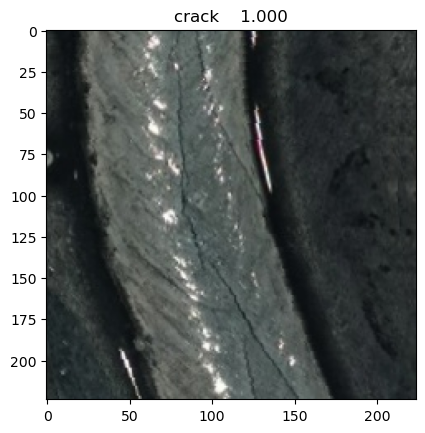

In [5]:
# predict
import torch
import json
import numpy
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
transforms = torchvision.transforms.Compose(
        [torchvision.transforms.Resize((224,224)),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image_path = r'E:\py_program\DeepLearning\data_set\MT\val\crack\276.jpg'
image = Image.open(image_path)
plt.imshow(image)
image = transforms(image)
image = torch.unsqueeze(image, dim=0)

with open('./VGG/VGG_label_dic.json', 'r') as file:
    cla_label = json.load(file)
    print(cla_label)

VGG = vgg_mine(num_class=3)
# VGG.load_state_dict(torch.load('./VGG/VGG.pth')) #nowmodel

VGG.load_state_dict(torch.load(r'E:\py_program\DeepLearning\VGG\bigmodel\VGG.pth')) #bigmodel


VGG.to('cpu')
with torch.no_grad():
    output = VGG(image)
    output = torch.squeeze(output, dim=0)
    # print(output)
    output = torch.softmax(output, dim=0)
    index = torch.argmax(output).numpy()
    label = cla_label[str(index)]
    rate = output[index].numpy()
    print(label, rate)
plt.title(cla_label[str(index)] + '    %.3f' % output[index].item())
plt.show()

Plot

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'] [0.03861, 0.00053, 0.00587, 5e-05, 2e-05, 0.00185, 0.00123, 0.00104, 1e-05, 0.0, 1e-05, 0.0, 1e-05, 0.0, 0.0] [0.915, 0.915, 0.941, 0.935, 0.935, 0.856, 0.935, 0.915, 0.908, 0.915, 0.915, 0.915, 0.915, 0.915, 0.915]


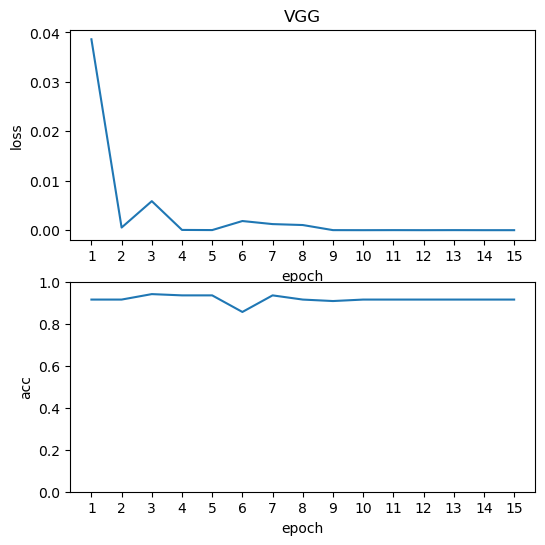

In [6]:
# plot
import matplotlib.pyplot as plt
epoch = []
train_loss = []
acc = []
def cvtdata(data):
    data = data.split(':')
    data = data[1].split('/')
    data = data[0]
    return data

with open('./VGG/train_data.txt', 'r') as txt:
    for i in txt.readlines():
        data = i
        data_i = data.split(' ')
        # print(data_i)
        # print(float(data_i[0][6]))
        epoch_i = cvtdata(data_i[0])      
        train_loss_i = float(data_i[1][11:])
        acc_i = float(data_i[2][8:])
        epoch.append(epoch_i)
        train_loss.append(train_loss_i)
        acc.append(acc_i)
print(epoch, train_loss, acc)
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(epoch, train_loss)

plt.title('VGG')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(2,1,2)

plt.plot(epoch, acc)

# plt.title('AlexNet')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.ylim(0,1)
plt.show()

In [7]:
# 可视化1
import cv2
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torch.utils.data
import json

# 图像变换
transform = torchvision.transforms.Compose(
    [
    # torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image = Image.open(r'E:\py_program\DeepLearning\data_set\MT\val\crack\038.jpg')
# plt.imshow(image)
image = transform(image)

# 添加batch维度
image = torch.unsqueeze(image, dim=0)

# 读取label字典 {'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}
with open('./VGG/VGG_label_dic.json', 'r') as file:
    class_dic = json.load(file)
    # print(class_dic)


# run model
# AlexNet = AlexNet()
# model_weight_path = './AlexNet/AlexNet.pth'


# AlexNet.load_state_dict(torch.load(model_weight_path))
# # print(AlexNet)
# AlexNet.eval()
# print(AlexNet.feature.children())

with torch.no_grad():
    out1 = image
    num=1
    for index, layer in enumerate(VGG.children()):
        if index == 0:
            for i in layer:
                num+=1
                out1=i(out1)
                if num ==8:
                    out = torch.squeeze(out1)
                    out = torch.permute(out, (1, 2, 0))
                    print(out.shape)
                    fig = plt.figure(1, figsize=(20,20))
                    # print(fig)
                    for i in range(20):
            
                        pic = out[:, :, i].numpy()
                        # print(pic.shape)
                        plt.subplot(4,5,i+1)
                        plt.imshow(pic)
                    # photo = photo/out.shape[2]
                    # photo = cv2.resize(photo, (1066,799))
                    # plt.imshow(photo)
                    plt.show()
                    break
                    
    # predict
    output = VGG(image)
    output = torch.squeeze(output)  # 压缩batch维度
    predict = torch.softmax(output, dim=0)
    index = torch.argmax(predict).numpy().item()

    print(class_dic[str(index)], predict[index].item())
# plt.title(class_dic[str(index)] + '    %.3f' % predict[index].item())
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\py_program\\DeepLearning\\data_set\\MT\\val\\crack\\038.jpg'

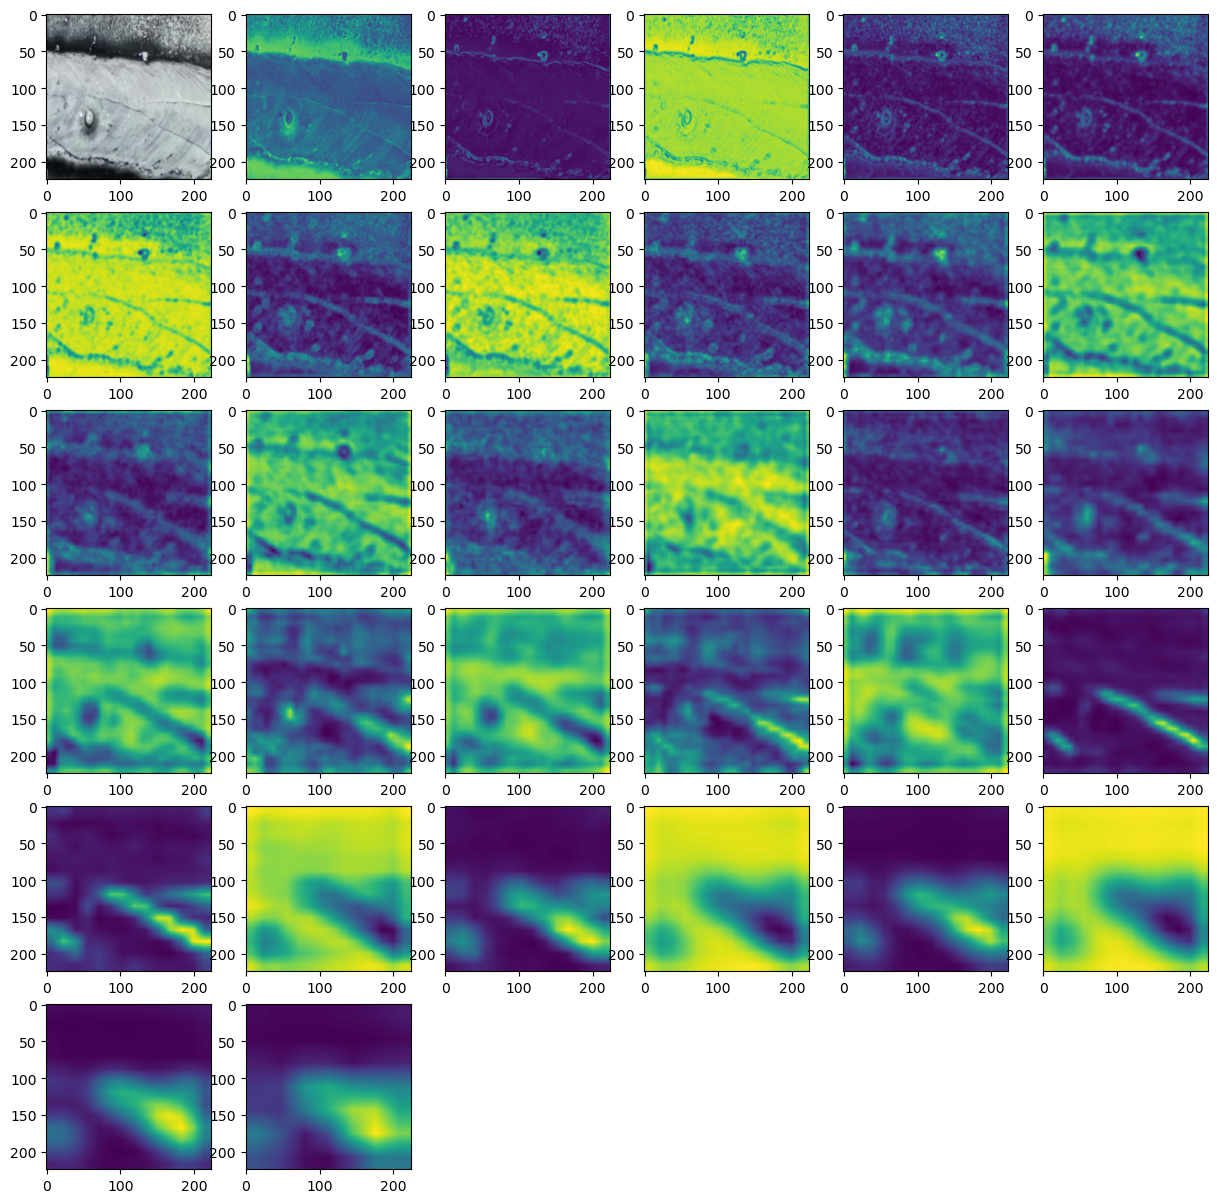

crack 1.0


In [ ]:
# 可视化2
import cv2
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torch.utils.data
import json
VGG.cpu()
# 图像变换
transform = torchvision.transforms.Compose(
    [
        # torchvision.transforms.Resize(256),
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image = Image.open(r'E:\py_program\DeepLearning\data_set\MT\val\crack\2101.jpg')
plt.figure(1, figsize=(15,15))

plt.subplot(6,6,1)
plt.imshow(image)
image = transform(image)

# 添加batch维度
image = torch.unsqueeze(image, dim=0)

# 读取label字典 {'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}
with open('./VGG/VGG_label_dic.json', 'r') as file:
    class_dic = json.load(file)
    # print(class_dic)


# run model
# AlexNet = AlexNet()
# model_weight_path = './AlexNet/AlexNet.pth'


# AlexNet.load_state_dict(torch.load(model_weight_path))
# # print(AlexNet)
# AlexNet.eval()
# print(AlexNet.feature.children())

with torch.no_grad():
    out1 = image
    num=1
    photo=(0)
    for index, layer in enumerate(VGG.children()):
        if index == 0:
            for i in layer:
                num+=1
                out1=i(out1)
                out = torch.squeeze(out1)
                out = torch.permute(out, (1, 2, 0))
                for m in range(out.shape[2]):
                    pic = out[:, :, m].numpy()
                    photo += pic
                photo = photo/out.shape[2]
                photo = cv2.resize(photo, (224,224))
                plt.subplot(6,6,num)
                plt.imshow(photo)
                photo=(0)
            plt.show()
                # break
                            
# predict
    output = VGG(image)
    output = torch.squeeze(output)  # 压缩batch维度
    predict = torch.softmax(output, dim=0)
    index = torch.argmax(predict).numpy().item()

    print(class_dic[str(index)], predict[index].item())
# plt.title(class_dic[str(index)] + '    %.3f' % predict[index].item())
# plt.show()

1
1
torch.Size([7, 7])


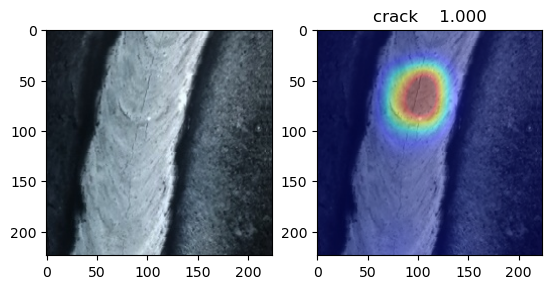

In [9]:
#GradCAM
from torchvision.models import vgg16
import math
import cv2
import torch
import torch.autograd as autograd
import numpy as np
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
img_path = r'E:\py_program\DeepLearning\data_set\MT\val\crack\441.jpg'     # 输入图片的路径
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
net = VGG   # 导入模型
net.cpu()
img_I = Image.open(img_path)
plt.subplot(1,2,1)
plt.imshow(img_I)
img_I = preprocess(img_I)
img_I = torch.unsqueeze(img_I, 0)


#----------------------------------------------------------------------------------------------------------
feature_map = []     # 建立列表容器，用于盛放输出特征图
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
hook_f = net.features.register_forward_hook(forward_hook)    # 对net.layer4这一层注册前向传播
grad = []     # 建立列表容器，用于盛放特征图的梯度
def backward_hook(module, inp, outp):    # 定义hook 
    grad.append(outp)    # 把输出装入列表grad
hook_b = net.features.register_full_backward_hook(backward_hook)    # 对net.features这一层注册反向传播

#----------------------------------------------------------------------------------------------------------


orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
out = net(img)     # 前向传播 
hook_f.remove()
print(len(feature_map))
cls_idx = torch.argmax(out).item()    # 获取预测类别编码 
score = out[:, cls_idx]   # 获取预测类别分数
a = feature_map[0].shape
channel = a[1]
net.zero_grad()
score.backward(retain_graph=True)    # 由预测类别分数反向传播
hook_b.remove()
print(len(grad[0][0]))
weights = grad[0][0].squeeze(0).mean(dim=(1, 2))    # 获得权重
grad_cam = (weights.view(channel,1,1) * feature_map[0].squeeze(0)).sum(0)
print(grad_cam.shape)


def _normalize(cams: Tensor) -> Tensor:
        """CAM normalization"""
        cams.sub_(cams.flatten(start_dim=-2).min(-1).values.unsqueeze(-1).unsqueeze(-1))
        cams.div_(cams.flatten(start_dim=-2).max(-1).values.unsqueeze(-1).unsqueeze(-1))
        return cams

grad_cam = _normalize(F.relu(grad_cam, inplace=True)).cpu()
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

def overlay_mask(img: Image.Image, mask: Image.Image, colormap: str = 'jet', alpha: float = 0.6) -> Image.Image:
    if not isinstance(img, Image.Image) or not isinstance(mask, Image.Image):
        raise TypeError('img and mask arguments need to be PIL.Image')
    if not isinstance(alpha, float) or alpha < 0 or alpha >= 1:
        raise ValueError('alpha argument is expected to be of type float between 0 and 1')
    cmap = cm.get_cmap(colormap) 

    # Resize mask and apply colormap
    overlay = mask.resize(img.size, resample=Image.BICUBIC)
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, 0:3]).astype(np.uint8)
    # Overlay the image with the mask
    overlayed_img = Image.fromarray((alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8))
    return overlayed_img

result = overlay_mask(orign_img, mask) 
with torch.no_grad():
    output = net(img_I)
    output = torch.squeeze(output)  # 压缩batch维度
    predict = torch.softmax(output, dim=0)
    index = torch.argmax(predict).numpy().item()
    
# result = overlay_mask(orign_img, mask) 
plt.subplot(1,2,2)
plt.title(cla_label[str(index)] + '    %.3f' % predict[index].item())


plt.imshow(result)



# result.save(save_path)
plt.show()